In [1]:
import argparse, os, sys, glob, yaml, math, random
import cv2
import datetime, time
import numpy as np
from omegaconf import OmegaConf
from collections import OrderedDict
from tqdm import trange, tqdm
from einops import repeat
from einops import rearrange, repeat
from functools import partial
import torch
from pytorch_lightning import seed_everything

from funcs import load_model_checkpoint, load_video_batch, load_prompts, load_idx, load_traj, load_image_batch, get_filelist, save_videos, save_videos_with_bbox
from funcs import batch_ddim_inversion, batch_ddim_sampling_freetraj
from utils.utils import instantiate_from_config

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

/notebooks/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
name="inversion_test"

ckpt='../../checkpoints/base_512_v2/model.ckpt'
config='../../configs/inference_t2v_freetraj_512_v2.0.yaml'

res_dir="../../results_inversion"
ref_path="../../assets/reference_examples/car-roundabout-24.mp4"
prompt_ref_file="../../prompts/inversion/text_ref.txt"
prompt_gen_file="../../prompts/inversion/text.txt"
idx_file="../../prompts/inversion/idx.txt"

In [3]:
## step 1: model config
## -----------------------------------------------------------------
config = OmegaConf.load(config)
model_config = config.pop("model", OmegaConf.create())
model = instantiate_from_config(model_config)
model = model.cuda(0)
assert os.path.exists(ckpt), f"Error: checkpoint [{ckpt}] Not Found!"
model = load_model_checkpoint(model, ckpt)
model.eval()




max_size = 512

# load reference video
video_tmp = cv2.VideoCapture(ref_path)
init_frames = int(video_tmp.get(cv2.CAP_PROP_FRAME_COUNT))
init_height = int(video_tmp.get(cv2.CAP_PROP_FRAME_HEIGHT))
init_width = int(video_tmp.get(cv2.CAP_PROP_FRAME_WIDTH))
print(f"Initial shape: {init_frames} x {init_height} x {init_width}")

# fix frames number to avoid OOM
frames = min(model.temporal_length, init_frames)
print(f"Frame cut: {frames} x {init_height} x {init_width}")

assert (max_size % 64 == 0), "Error: size should be multiple of 64"
if init_height > init_width:
    height = max_size
    width = int((height / init_height) * init_width)
    print(f"Resizing: {frames} x {height} x {width}")
    width = ((width - 1) // 64 + 1) * 64
    print(f"Aligning: {frames} x {height} x {width}")
else:
    width = max_size
    height = int((width / init_width) * init_height)
    print(f"Resizing: {frames} x {height} x {width}")
    height = ((height - 1) // 64 + 1) * 64
    print(f"Aligning: {frames} x {height} x {width}")

video = load_video_batch([ref_path], 1, video_size=(height, width), video_frames=frames).to(model.device)
# B x C x F x H x W
# [-1, 1]
#write_video("test.mp4", ((video[0].permute(1, 2, 3, 0).cpu() + 1) / 2 * 255).to(dtype=torch.uint8), fps=args.savefps)
#save_videos(video.unsqueeze(1), os.path.join(args.savedir, 'ref'), filenames, fps=args.savefps)

AE working on z of shape (1, 4, 64, 64) = 16384 dimensions.


/notebooks/venv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
INFO:root:Loaded ViT-H-14 model config.


>>> model checkpoint loaded.
Initial shape: 24 x 480 x 864
Frame cut: 16 x 480 x 864
Resizing: 16 x 284 x 512
Aligning: 16 x 320 x 512


In [4]:
fps = 16


# video -> latents
latents = model.encode_first_stage_2DAE(video)
vs = video.shape
video = video.cpu()
#del video
torch.cuda.empty_cache()

assert os.path.exists(prompt_ref_file), "Error: reference video prompt file NOT Found!"
prompt_ref_list = load_prompts(prompt_ref_file)
# embed text
text_ref_emb = model.get_learned_conditioning(prompt_ref_list)
fps = torch.tensor([fps]*latents.shape[0]).to(model.device).long()
cond = {"c_crossattn": [text_ref_emb], "fps": fps}

In [5]:
ddim_steps = 50
ddim_eta = 0.0
unconditional_guidance_scale = 12.0

# inversion
out = batch_ddim_inversion(
    model, cond, latents, ddim_steps, ddim_eta, unconditional_guidance_scale, 
    log_every_t=1, return_cross_attn=True
)

DDIM scale True
ddim device cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]/notebooks/venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/notebooks/venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 50/50 [02:59<00:00,  3.59s/it]


In [6]:
inversed, inters = out

In [7]:
len(inters['cmaps'])

50

In [8]:
len(inters['cmaps'][0])

24

In [9]:
cmaps = []
for i in range(len(inters['cmaps'])):
    cmaps_curr = inters['cmaps'][i]
    cmaps.append([])
    for j in range(len(cmaps_curr)):
        if len(cmaps_curr[j]) > 0:
            cmaps[-1].append(cmaps_curr[j][0][0])

In [17]:
for c in cmaps[0]:
    print(c.shape)

torch.Size([80, 2560, 77])
torch.Size([80, 2560, 77])
torch.Size([160, 640, 77])
torch.Size([160, 640, 77])
torch.Size([320, 160, 77])
torch.Size([320, 160, 77])
torch.Size([320, 160, 77])
torch.Size([320, 160, 77])
torch.Size([320, 160, 77])
torch.Size([160, 640, 77])
torch.Size([160, 640, 77])
torch.Size([160, 640, 77])
torch.Size([80, 2560, 77])
torch.Size([80, 2560, 77])
torch.Size([80, 2560, 77])


In [11]:
prompt_ref_list

['A car turning along the road.']

In [12]:
text_ref_emb.shape

torch.Size([1, 77, 1024])

In [33]:
import open_clip

open_clip.tokenize(['A car turning along the road.'])

tensor([[49406,   320,  1615,  4976,  2528,   518,  1759,   269, 49407,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

In [32]:
open_clip.decode(open_clip.tokenize(['A car turning along the road.'])[0])

'<start_of_text>a car turning along the road . <end_of_text>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'

In [36]:
ind = 1

In [65]:
c = cmaps[0][0][..., ind+2]

In [66]:
sz = int((c.shape[-1] / (inversed.shape[-1] / inversed.shape[-2])) ** (1/2))
c = c.reshape(-1, frames, sz, int(sz * 1.6))

In [67]:
c = c.mean(dim=0)

In [68]:
plt.imshow(c[0])
plt.show()

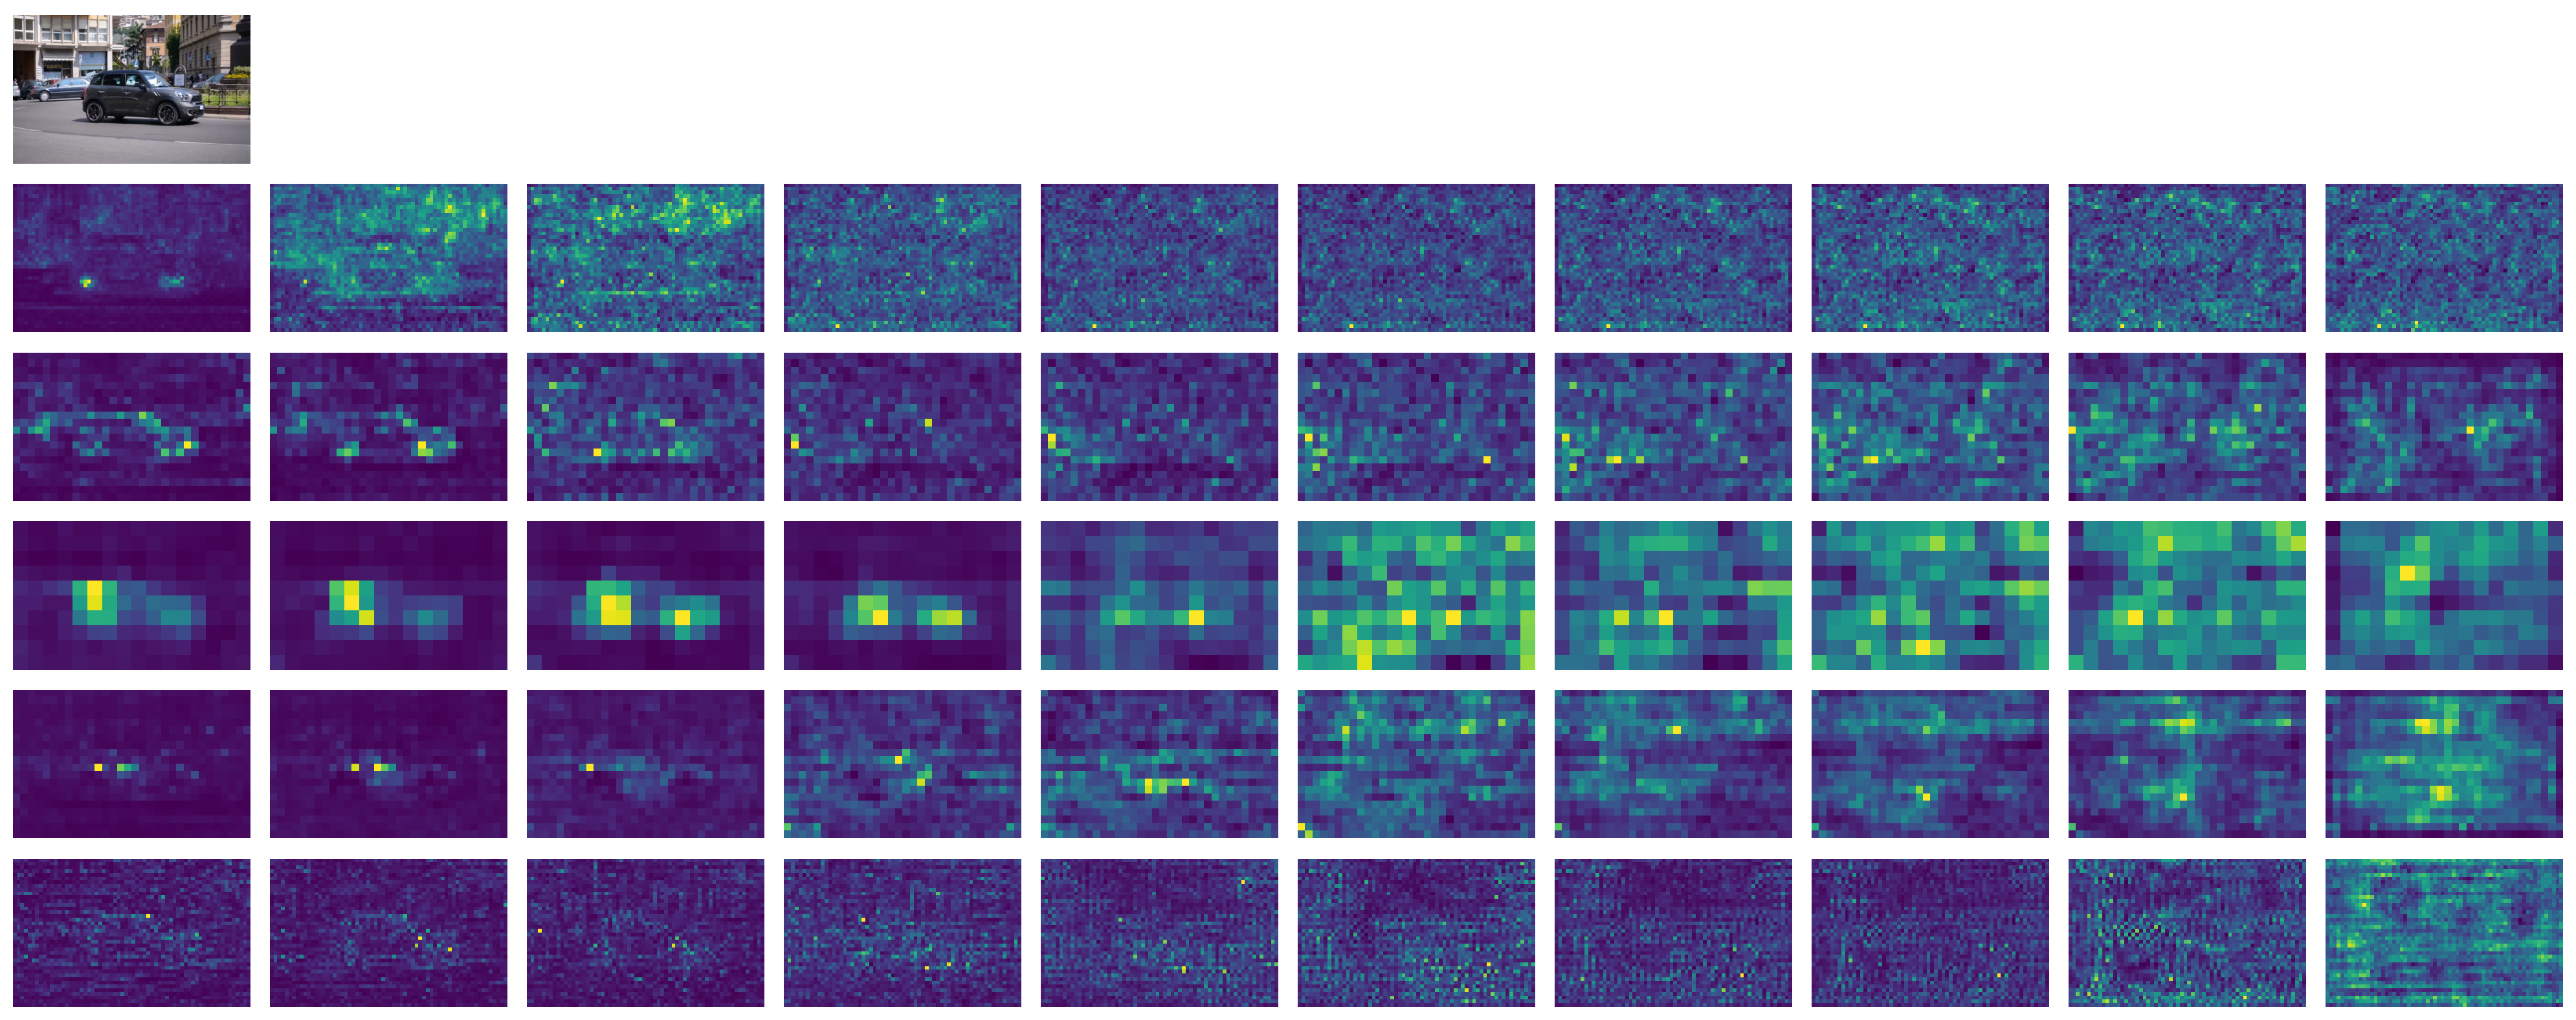

In [73]:
from torchvision.utils import make_grid


frame = 0
ind = 1 # car


#plt.title(prompt_ref_list[0])



fig, axs = plt.subplots(ncols=10, nrows=5+1, figsize=(20, 8))
vid = video[0, :, frame, ...].permute(1, 2, 0)
vid = ((vid + 1) / 2 * 255).to(dtype=torch.uint8)
axs[0, 0].imshow(vid)
for ax in axs[0, :]:
    ax.axis('off')


for i in range(10):
    # timesteps
    cmaps_curr = cmaps[i * 5]
    for j in range(5):
        # layers
        c = cmaps_curr[j * 3]
        # select word, +1 for <start_of_text>
        c = c[..., ind+1]
        # reshape
        sz = int((c.shape[-1] / (inversed.shape[-1] / inversed.shape[-2])) ** (1/2))
        c = c.reshape(-1, frames, sz, int(sz * 1.6))
        c = c.mean(dim=0)[frame]
        
        axs[j+1, i].imshow(c)
        axs[j+1, i].axis('off')
        


plt.tight_layout()

In [99]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize

frame = 0
ind = 1 # car


#plt.title(prompt_ref_list[0])



fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(20, 8), height_ratios=[1, 3])


vid = video[0, :, frame, ...].permute(1, 2, 0)
vid = ((vid + 1) / 2 * 255).to(dtype=torch.uint8)
axs[0].imshow(vid)
axs[0].axis('off')
axs[0].set_title(prompt_ref_list[0])

grid = []
for j in range(5):
    for i in range(10):
        # timesteps
        cmaps_curr = cmaps[i * 5]
        # layers
        c = cmaps_curr[j * 3]
        # select word, +1 for <start_of_text>
        c = c[..., ind+1]
        # reshape
        sz = int((c.shape[-1] / (inversed.shape[-1] / inversed.shape[-2])) ** (1/2))
        c = c.reshape(-1, frames, sz, int(sz * 1.6))
        c = c.mean(dim=0)[frame].unsqueeze(0)
        mx = c.max()
        mn = c.min()
        c = (c - mn) / (mx - mn)
        
        if len(grid) == 0:
            grid.append(c)
        else:
            c = resize(c, grid[0].shape[1:])
            grid.append(c)
        
grid = make_grid(grid, nrow=10)
axs[1].imshow(grid.mean(0))
w = grid.shape[-1] / 10
axs[1].set_xticks(np.arange(10) * w + w / 2, np.arange(10) * 5)
axs[1].set_xlabel('timestep')
h = grid.shape[-2] / 5
axs[1].set_yticks(np.arange(5) * h + h / 2, np.arange(5) * 3)
axs[1].set_ylabel('layer')
axs[1].set_title('token: "car"')

plt.tight_layout()

/notebooks/venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [101]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize

frame = 0
ind = 2 # turning


#plt.title(prompt_ref_list[0])



fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(20, 8), height_ratios=[1, 3])


vid = video[0, :, frame, ...].permute(1, 2, 0)
vid = ((vid + 1) / 2 * 255).to(dtype=torch.uint8)
axs[0].imshow(vid)
axs[0].axis('off')
axs[0].set_title(prompt_ref_list[0])

grid = []
for j in range(5):
    for i in range(10):
        # timesteps
        cmaps_curr = cmaps[i * 5]
        # layers
        c = cmaps_curr[j * 3]
        # select word, +1 for <start_of_text>
        c = c[..., ind+1]
        # reshape
        sz = int((c.shape[-1] / (inversed.shape[-1] / inversed.shape[-2])) ** (1/2))
        c = c.reshape(-1, frames, sz, int(sz * 1.6))
        c = c.mean(dim=0)[frame].unsqueeze(0)
        mx = c.max()
        mn = c.min()
        c = (c - mn) / (mx - mn)
        
        if len(grid) == 0:
            grid.append(c)
        else:
            c = resize(c, grid[0].shape[1:])
            grid.append(c)
        
grid = make_grid(grid, nrow=10)
axs[1].imshow(grid.mean(0))
w = grid.shape[-1] / 10
axs[1].set_xticks(np.arange(10) * w + w / 2, np.arange(10) * 5)
axs[1].set_xlabel('timestep')
h = grid.shape[-2] / 5
axs[1].set_yticks(np.arange(5) * h + h / 2, np.arange(5) * 3)
axs[1].set_ylabel('layer')
axs[1].set_title('token: "turning"')

plt.tight_layout()

/notebooks/venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


/notebooks/venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


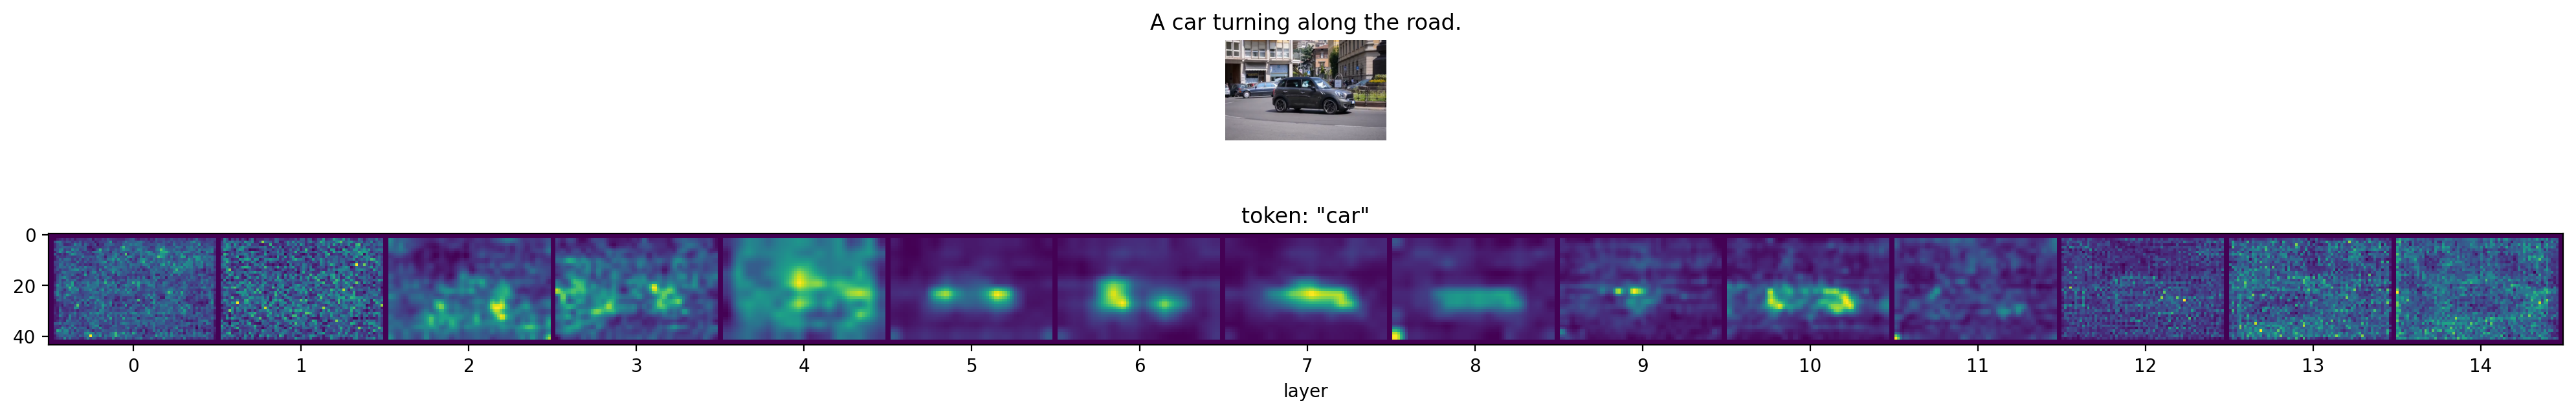

In [112]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize

frame = 0
ind = 1 # car





fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(20, 4), height_ratios=[1, 4])


vid = video[0, :, frame, ...].permute(1, 2, 0)
vid = ((vid + 1) / 2 * 255).to(dtype=torch.uint8)
axs[0].imshow(vid)
axs[0].axis('off')
axs[0].set_title(prompt_ref_list[0])

grid = []
for j in range(15):
    # layer
    cmaps_l = []
    for i in range(50):
        # timesteps
        cmaps_curr = cmaps[i]
        # layers
        c = cmaps_curr[j]
        # select word, +1 for <start_of_text>
        c = c[..., ind+1]
        # reshape
        sz = int((c.shape[-1] / (inversed.shape[-1] / inversed.shape[-2])) ** (1/2))
        c = c.reshape(-1, frames, sz, int(sz * 1.6))
        c = c.mean(dim=0)[frame].unsqueeze(0)
        
        if len(grid) == 0:
            cmaps_l.append(c)
        else:
            c = resize(c, grid[0].shape[1:])
            cmaps_l.append(c)
    c = torch.stack(cmaps_l).mean(0)
    mx = c.max()
    mn = c.min()
    c = (c - mn) / (mx - mn)
    grid.append(c)
        
grid = make_grid(grid, nrow=15)
axs[1].imshow(grid.mean(0))
w = grid.shape[-1] / 15
axs[1].set_xticks(np.arange(15) * w + w / 2, np.arange(15))
axs[1].set_xlabel('layer')
axs[1].set_title('token: "car"')

plt.tight_layout()

/notebooks/venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


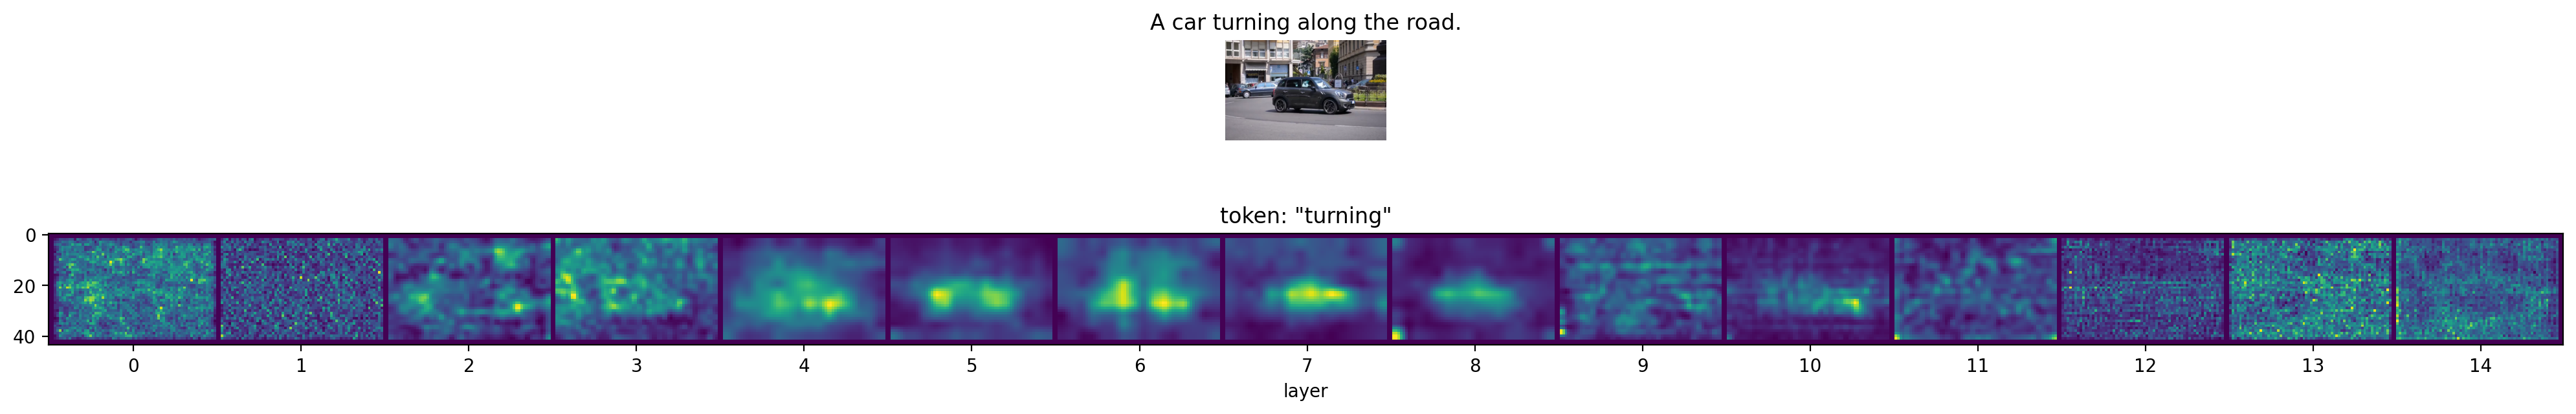

In [113]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize

frame = 0
ind = 2 # car





fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(20, 4), height_ratios=[1, 4])


vid = video[0, :, frame, ...].permute(1, 2, 0)
vid = ((vid + 1) / 2 * 255).to(dtype=torch.uint8)
axs[0].imshow(vid)
axs[0].axis('off')
axs[0].set_title(prompt_ref_list[0])

grid = []
for j in range(15):
    # layer
    cmaps_l = []
    for i in range(50):
        # timesteps
        cmaps_curr = cmaps[i]
        # layers
        c = cmaps_curr[j]
        # select word, +1 for <start_of_text>
        c = c[..., ind+1]
        # reshape
        sz = int((c.shape[-1] / (inversed.shape[-1] / inversed.shape[-2])) ** (1/2))
        c = c.reshape(-1, frames, sz, int(sz * 1.6))
        c = c.mean(dim=0)[frame].unsqueeze(0)
        
        if len(cmaps_l) == 0:
            cmaps_l.append(c)
        else:
            c = resize(c, cmaps_l[0].shape[1:])
            cmaps_l.append(c)
    c = torch.stack(cmaps_l).mean(0)
    mx = c.max()
    mn = c.min()
    c = (c - mn) / (mx - mn)
    grid.append(c)
        
grid = make_grid(grid, nrow=15)
axs[1].imshow(grid.mean(0))
w = grid.shape[-1] / 15
axs[1].set_xticks(np.arange(15) * w + w / 2, np.arange(15))
axs[1].set_xlabel('layer')
axs[1].set_title('token: "turning"')

plt.tight_layout()

/notebooks/venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


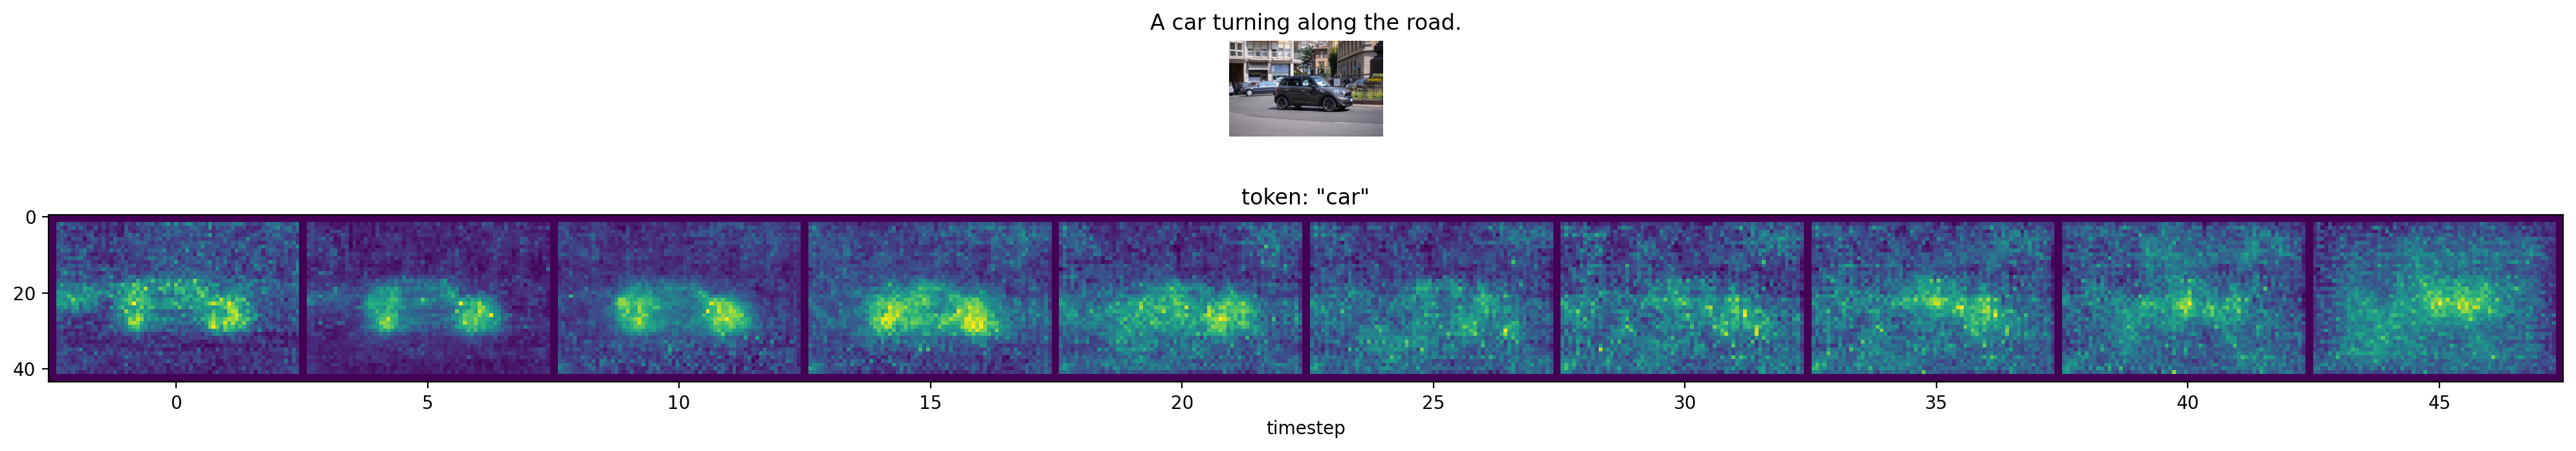

In [114]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize

frame = 0
ind = 1 # car





fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(20, 4), height_ratios=[1, 4])


vid = video[0, :, frame, ...].permute(1, 2, 0)
vid = ((vid + 1) / 2 * 255).to(dtype=torch.uint8)
axs[0].imshow(vid)
axs[0].axis('off')
axs[0].set_title(prompt_ref_list[0])

grid = []
for i in range(10):
    # layer
    cmaps_t = []
    for j in range(15):
        # timesteps
        cmaps_curr = cmaps[i*5]
        # layers
        c = cmaps_curr[j]
        # select word, +1 for <start_of_text>
        c = c[..., ind+1]
        # reshape
        sz = int((c.shape[-1] / (inversed.shape[-1] / inversed.shape[-2])) ** (1/2))
        c = c.reshape(-1, frames, sz, int(sz * 1.6))
        c = c.mean(dim=0)[frame].unsqueeze(0)
        
        if len(cmaps_t) == 0:
            cmaps_t.append(c)
        else:
            c = resize(c, cmaps_t[0].shape[1:])
            cmaps_t.append(c)
    c = torch.stack(cmaps_t).mean(0)
    mx = c.max()
    mn = c.min()
    c = (c - mn) / (mx - mn)
    grid.append(c)
        
grid = make_grid(grid, nrow=10)
axs[1].imshow(grid.mean(0))
w = grid.shape[-1] / 10
axs[1].set_xticks(np.arange(10) * w + w / 2, np.arange(10) * 5)
axs[1].set_xlabel('timestep')
axs[1].set_title('token: "car"')

plt.tight_layout()

/notebooks/venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


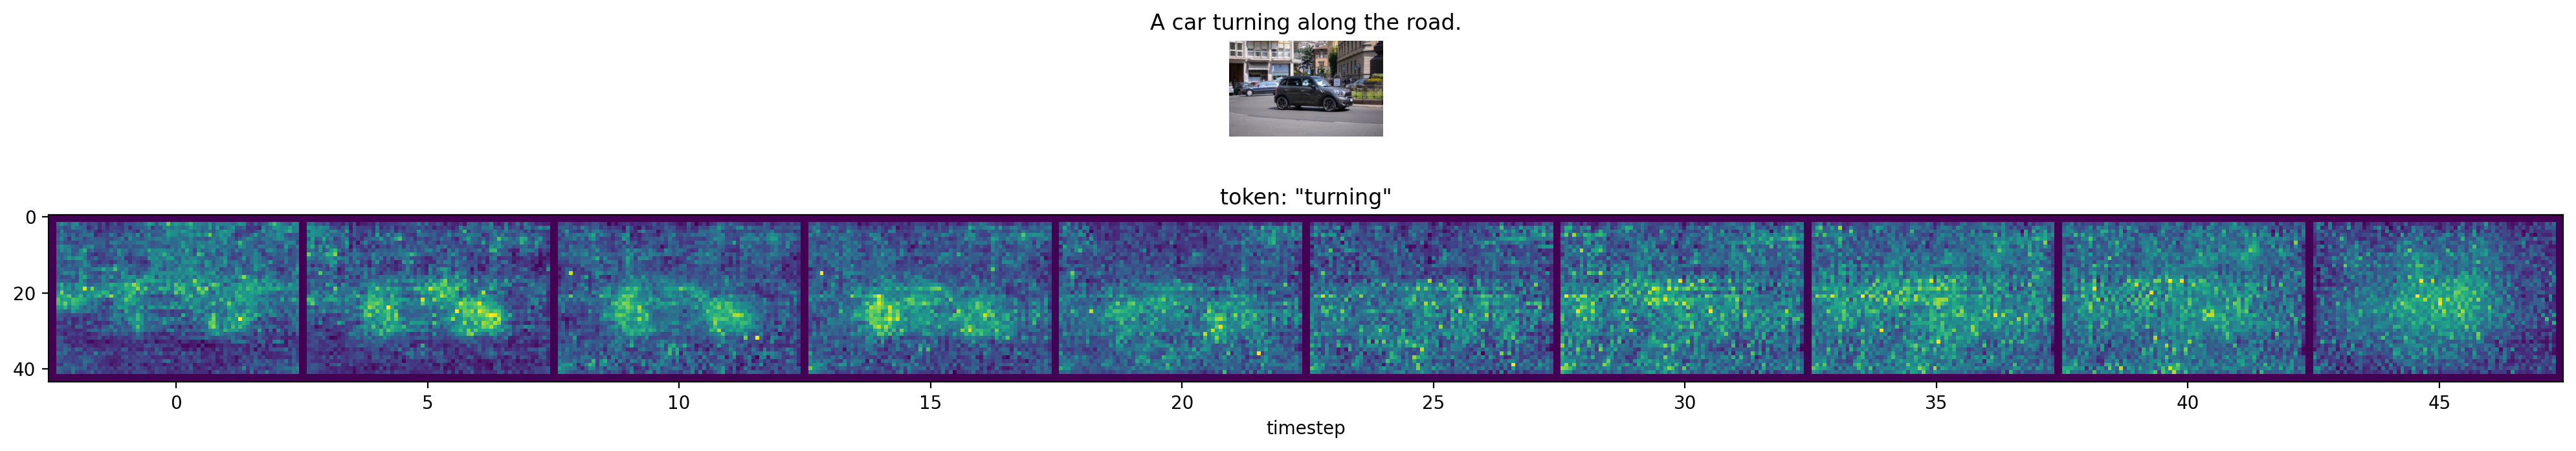

In [115]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize

frame = 0
ind = 2 # car





fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(20, 4), height_ratios=[1, 4])


vid = video[0, :, frame, ...].permute(1, 2, 0)
vid = ((vid + 1) / 2 * 255).to(dtype=torch.uint8)
axs[0].imshow(vid)
axs[0].axis('off')
axs[0].set_title(prompt_ref_list[0])

grid = []
for i in range(10):
    # timesteps
    cmaps_t = []
    for j in range(15):
        # layer
        cmaps_curr = cmaps[i*5]
        # layers
        c = cmaps_curr[j]
        # select word, +1 for <start_of_text>
        c = c[..., ind+1]
        # reshape
        sz = int((c.shape[-1] / (inversed.shape[-1] / inversed.shape[-2])) ** (1/2))
        c = c.reshape(-1, frames, sz, int(sz * 1.6))
        c = c.mean(dim=0)[frame].unsqueeze(0)
        
        if len(cmaps_t) == 0:
            cmaps_t.append(c)
        else:
            c = resize(c, cmaps_t[0].shape[1:])
            cmaps_t.append(c)
    c = torch.stack(cmaps_t).mean(0)
    mx = c.max()
    mn = c.min()
    c = (c - mn) / (mx - mn)
    grid.append(c)
        
grid = make_grid(grid, nrow=10)
axs[1].imshow(grid.mean(0))
w = grid.shape[-1] / 10
axs[1].set_xticks(np.arange(10) * w + w / 2, np.arange(10) * 5)
axs[1].set_xlabel('timestep')
axs[1].set_title('token: "turning"')

plt.tight_layout()

/notebooks/venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


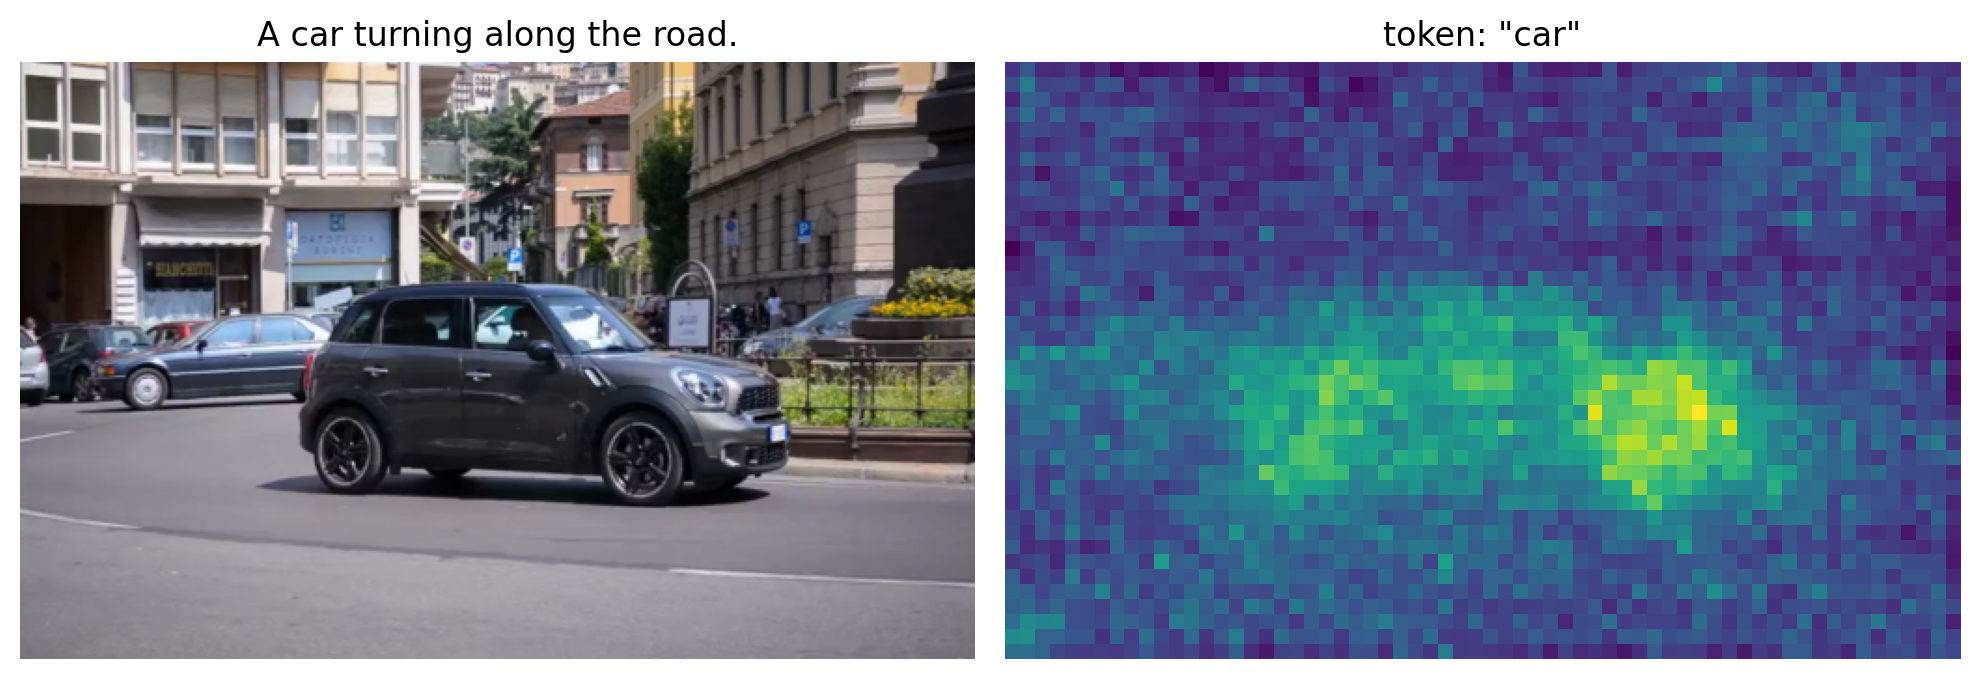

In [116]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize

frame = 0
ind = 1 # car





fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))


vid = video[0, :, frame, ...].permute(1, 2, 0)
vid = ((vid + 1) / 2 * 255).to(dtype=torch.uint8)
axs[0].imshow(vid)
axs[0].axis('off')
axs[0].set_title(prompt_ref_list[0])

cmaps_l = []
for i in range(50):
    # timesteps
    cmaps_t = []
    for j in range(15):
        # layer
        cmaps_curr = cmaps[i]
        # layers
        c = cmaps_curr[j]
        # select word, +1 for <start_of_text>
        c = c[..., ind+1]
        # reshape
        sz = int((c.shape[-1] / (inversed.shape[-1] / inversed.shape[-2])) ** (1/2))
        c = c.reshape(-1, frames, sz, int(sz * 1.6))
        c = c.mean(dim=0)[frame].unsqueeze(0)
        
        if len(cmaps_t) == 0:
            cmaps_t.append(c)
        else:
            c = resize(c, cmaps_t[0].shape[1:])
            cmaps_t.append(c)
    c = torch.stack(cmaps_t).mean(0)
    cmaps_l.append(c)

c = torch.stack(cmaps_l).mean(0)
        
axs[1].imshow(c[0])
axs[1].axis('off')
axs[1].set_title('token: "car"')

plt.tight_layout()

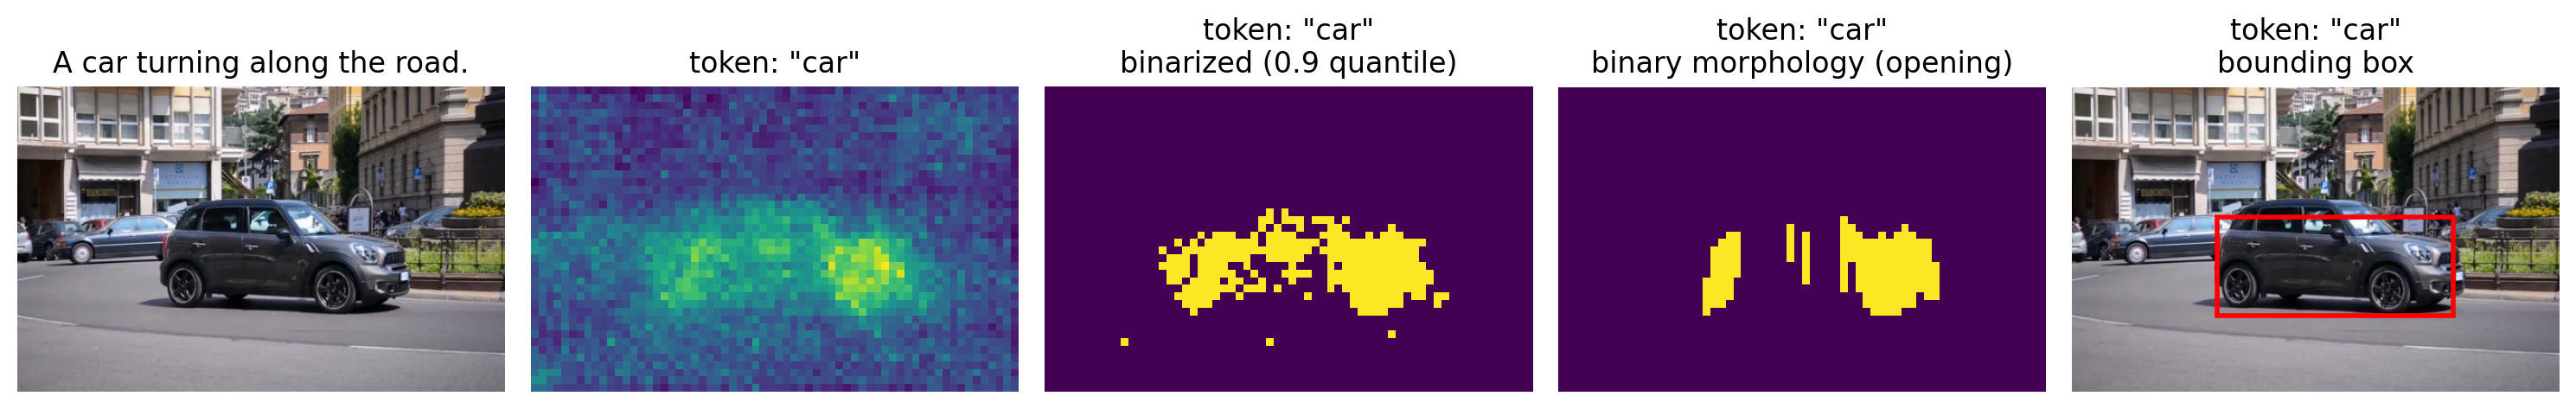

In [162]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize
import matplotlib.patches as patches


import cv2

frame = 0
ind = 1 # car





fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(15, 7))


vid = video[0, :, frame, ...].permute(1, 2, 0)
vid = ((vid + 1) / 2 * 255).to(dtype=torch.uint8)
axs[0].imshow(vid)
axs[0].axis('off')
axs[0].set_title(prompt_ref_list[0])

cmaps_l = []
for i in range(50):
    # timesteps
    cmaps_t = []
    for j in range(15):
        # layer
        cmaps_curr = cmaps[i]
        # layers
        c = cmaps_curr[j]
        # select word, +1 for <start_of_text>
        c = c[..., ind+1]
        # reshape
        sz = int((c.shape[-1] / (inversed.shape[-1] / inversed.shape[-2])) ** (1/2))
        c = c.reshape(-1, frames, sz, int(sz * 1.6))
        c = c.mean(dim=0)[frame].unsqueeze(0)
        
        if len(cmaps_t) == 0:
            cmaps_t.append(c)
        else:
            c = resize(c, cmaps_t[0].shape[1:])
            cmaps_t.append(c)
    c = torch.stack(cmaps_t).mean(0)
    cmaps_l.append(c)

c = torch.stack(cmaps_l).mean(0)

axs[1].imshow(c[0])
axs[1].axis('off')
axs[1].set_title('token: "car"')

plt.tight_layout()
               
# binarize
q = 0.9
thresh = np.quantile(c.numpy(), q)
c = c.numpy() > thresh
        
axs[2].imshow(c[0])
axs[2].axis('off')
axs[2].set_title(f'token: "car"\nbinarized ({q} quantile)')

# clean
# binary morphology (opening) to remove small noise
kernel = np.ones((5,5),np.uint8)
c_opening = cv2.morphologyEx(c.astype(np.uint8), cv2.MORPH_OPEN, kernel)
        
axs[3].imshow(c_opening[0])
axs[3].axis('off')
axs[3].set_title(f'token: "car"\nbinary morphology (opening)')

# compute bbox
x,y,w,h = cv2.boundingRect(cv2.findNonZero(c_opening[0]))
# get relative coords
ww, hh = c_opening[0].shape
x /= ww
w /= ww
y /= hh
h /= hh
# get new coords
x_new = x * vid.shape[0]
w_new = w * vid.shape[0]
y_new = y * vid.shape[1]
h_new = h * vid.shape[1]

axs[4].imshow(vid)
axs[4].axis('off')
rect = patches.Rectangle((x_new, y_new), w_new, h_new, linewidth=2, edgecolor='r', facecolor='none')
axs[4].add_patch(rect)
axs[4].set_title(f'token: "car"\nbounding box')


plt.tight_layout()

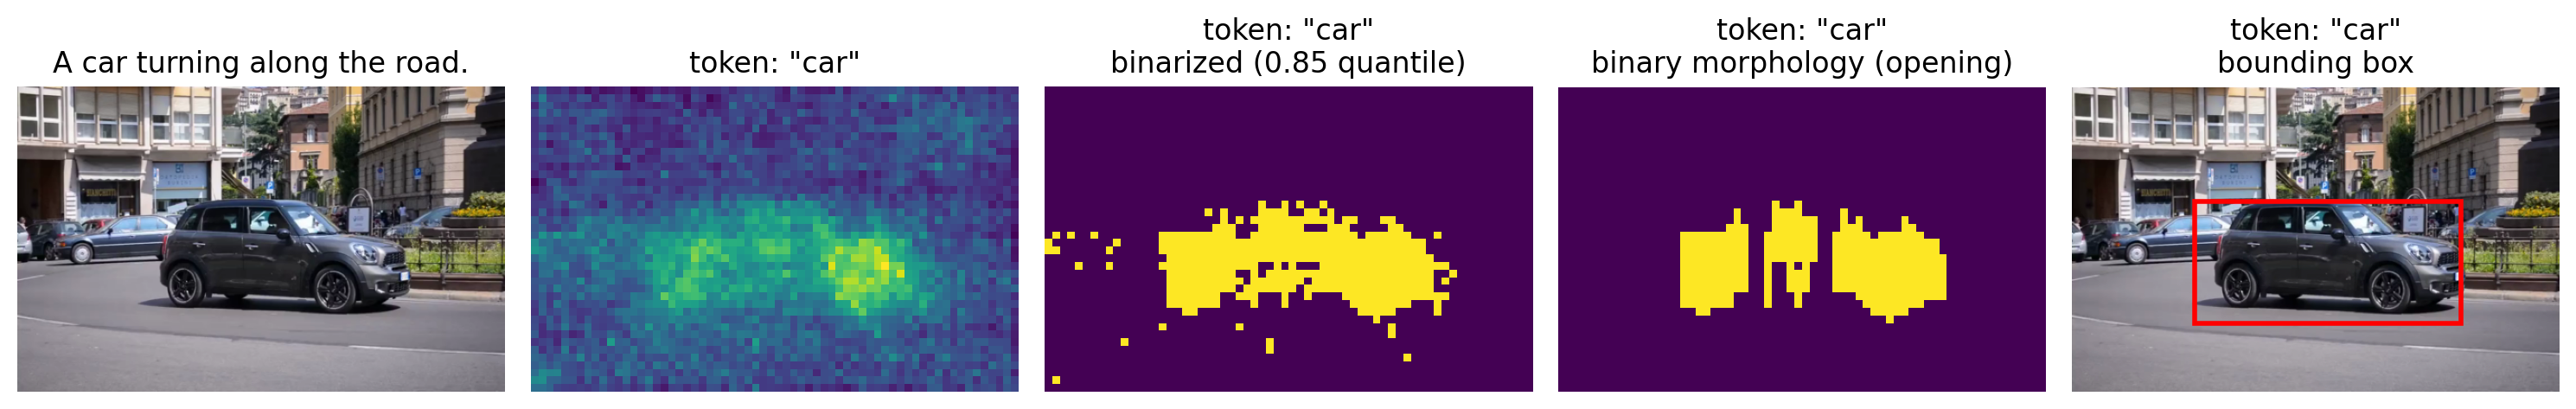

In [163]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize
import matplotlib.patches as patches


import cv2

frame = 0
ind = 1 # car





fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(15, 7))


vid = video[0, :, frame, ...].permute(1, 2, 0)
vid = ((vid + 1) / 2 * 255).to(dtype=torch.uint8)
axs[0].imshow(vid)
axs[0].axis('off')
axs[0].set_title(prompt_ref_list[0])

cmaps_l = []
for i in range(50):
    # timesteps
    cmaps_t = []
    for j in range(15):
        # layer
        cmaps_curr = cmaps[i]
        # layers
        c = cmaps_curr[j]
        # select word, +1 for <start_of_text>
        c = c[..., ind+1]
        # reshape
        sz = int((c.shape[-1] / (inversed.shape[-1] / inversed.shape[-2])) ** (1/2))
        c = c.reshape(-1, frames, sz, int(sz * 1.6))
        c = c.mean(dim=0)[frame].unsqueeze(0)
        
        if len(cmaps_t) == 0:
            cmaps_t.append(c)
        else:
            c = resize(c, cmaps_t[0].shape[1:])
            cmaps_t.append(c)
    c = torch.stack(cmaps_t).mean(0)
    cmaps_l.append(c)

c = torch.stack(cmaps_l).mean(0)

axs[1].imshow(c[0])
axs[1].axis('off')
axs[1].set_title('token: "car"')

plt.tight_layout()
               
# binarize
q = 0.85
thresh = np.quantile(c.numpy(), q)
c = c.numpy() > thresh
        
axs[2].imshow(c[0])
axs[2].axis('off')
axs[2].set_title(f'token: "car"\nbinarized ({q} quantile)')

# clean
# binary morphology (opening) to remove small noise
kernel = np.ones((5,5),np.uint8)
c_opening = cv2.morphologyEx(c.astype(np.uint8), cv2.MORPH_OPEN, kernel)
        
axs[3].imshow(c_opening[0])
axs[3].axis('off')
axs[3].set_title(f'token: "car"\nbinary morphology (opening)')

# compute bbox
x,y,w,h = cv2.boundingRect(cv2.findNonZero(c_opening[0]))
# get relative coords
ww, hh = c_opening[0].shape
x /= ww
w /= ww
y /= hh
h /= hh
# get new coords
x_new = x * vid.shape[0]
w_new = w * vid.shape[0]
y_new = y * vid.shape[1]
h_new = h * vid.shape[1]

axs[4].imshow(vid)
axs[4].axis('off')
rect = patches.Rectangle((x_new, y_new), w_new, h_new, linewidth=2, edgecolor='r', facecolor='none')
axs[4].add_patch(rect)
axs[4].set_title(f'token: "car"\nbounding box')


plt.tight_layout()